In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import networkx as nx # Used only for PROMTEHEE I visualisation (could be omitted if unnecessary)

# Print nice-looking tables
from tabulate import tabulate

from pymcdm import methods as mcdm_methods
from pymcdm import weights as mcdm_weights
from pymcdm import normalizations as norm
from pymcdm import correlations as corr
from pymcdm.methods.comet_tools import MethodExpert, ManualExpert
from pymcdm.helpers import rankdata, rrankdata, normalize_matrix

In [2]:
# For pretty printing
np.set_printoptions(suppress=True, precision=4)

# Normalization examples

In order to use some MCDA methods, data should be normalized first. Methods which need data to be normalized has build-in normalization, but, anyway, here's example of how to use normalization methods from our library.

In [3]:
# Random matrix with 5 alternatives and 7 criteria to demonstrate how normalization works
matrix = np.random.rand(5, 7) * 10
types = np.array([1, 1, 1, 1, -1, -1, 1])

normalization_methods = [
    norm.minmax_normalization,
    norm.max_normalization,
    norm.sum_normalization,
    norm.vector_normalization,
    norm.logarithmic_normalization
]

for method in normalization_methods:
    # Normalize matrix and print first three rows
    nmatrix = normalize_matrix(matrix, method, types)
    print(nmatrix[:3])

[[0.5243 1.     0.8007 0.8311 0.858  0.7    0.4552]
 [0.3957 0.     0.4281 1.     0.2017 0.8162 0.752 ]
 [0.     0.3528 1.     0.     0.8213 0.     0.3251]]
[[0.5358 1.     0.8389 0.8341 0.8539 0.6258 0.5885]
 [0.4103 0.0608 0.5377 1.     0.2007 0.7297 0.8127]
 [0.0242 0.3922 1.     0.0178 0.8174 0.     0.4902]]
[[0.2353 0.4676 0.285  0.3477 0.0302 0.1453 0.1877]
 [0.1801 0.0284 0.1827 0.4168 0.0055 0.2011 0.2591]
 [0.0106 0.1834 0.3397 0.0074 0.0242 0.0544 0.1563]]
[[0.4303 0.8346 0.5694 0.6037 0.8877 0.7062 0.3874]
 [0.3295 0.0508 0.365  0.7237 0.3858 0.7878 0.5351]
 [0.0194 0.3273 0.6787 0.0129 0.8597 0.2149 0.3227]]
[[ 0.3307  0.5706  0.2665  0.5193  0.2275  0.199   0.2048]
 [ 0.2778 -0.2824  0.2085  0.5643 -0.3371  0.2192  0.2422]
 [-0.2834  0.2854  0.2894 -0.4332  0.1533  0.138   0.1837]]


`normalize_matrix` requires `types` arguments, because normalization functions are designed to convert cost criteria into profit when normalize them. Here's an example of how one random vector could be normalized.

In [4]:
vec = np.random.rand(5) * 10
print(vec)
# Normalize as profit
print(norm.minmax_normalization(vec, cost=False))
# Normalize as cost
print(norm.minmax_normalization(vec, cost=True))

[9.9827 7.4555 8.6277 3.9279 3.756 ]
[1.     0.5941 0.7824 0.0276 0.    ]
[0.     0.4059 0.2176 0.9724 1.    ]


**Important**: convert data to `float` when use "raw" normalization functins.

# Example on real data
## Data
### Data description
We would use some electric vans data to demonstrate how different methods from our library could be used. Csv contains parametres of several electric vans. Every row is one alternative. First three columns contains alternative's code, van's name and manufacturer.

In [5]:
data = pd.read_csv('vans.csv')

We would only interested in numerical data and it would be our decision matrix:

In [6]:
matrix = data[data.columns[3:]].to_numpy()
print(matrix)

[[3000.    96.   145.   200.   610.    10.   120.    99.   120. ]
 [2000.   100.   145.   200.   610.    10.   120.    99.    90. ]
 [ 705.   120.   170.    80.   270.     4.    30.    24.    25. ]
 [ 613.   140.   180.   140.   400.     8.    40.    24.2   50. ]
 [ 350.   100.   110.    30.   196.     4.5   15.    10.5   12.9]
 [ 350.   100.   100.    30.   196.     4.5   15.    10.5   15.5]
 [ 350.   100.   150.    30.   196.     7.    35.    16.    18.7]
 [ 635.   110.   170.    49.   200.     8.    35.    22.5   31.5]
 [ 340.   150.   160.   110.   500.     6.    10.    35.    45. ]
 [ 750.    57.   110.    10.    80.     8.   120.    35.    24.4]]


### Weights

We would use equal weight for criteria:

In [7]:
weights = mcdm_weights.equal_weights(matrix)
print(weights)

[0.1111 0.1111 0.1111 0.1111 0.1111 0.1111 0.1111 0.1111 0.1111]


There's also some more advanced methods to determine weights in our library, like entropy and std methods.

In [8]:
print(mcdm_weights.entropy_weights(matrix))
print(mcdm_weights.standard_deviation_weights(matrix))

[0.1894 0.0152 0.0102 0.1709 0.0877 0.026  0.1814 0.1719 0.1473]
[0.6711 0.0195 0.0214 0.0542 0.1446 0.0017 0.0353 0.0254 0.0268]


### Criteria types

Functions in our library use `types` argument to determine which criteria are profit and should be maximized and which criteria are cost and should be minimized. $1$ means profit criteria and $-1$ means cost criteria. For this particular decision problem `types` vector would be defined as follows:

In [9]:
types = np.array([1, 1, 1, 1, 1, -1, -1, 1, -1])

Now we are prepared to show how MCDA methods from our library can be used.

## MCDA method examples

### TOPSIS method

First let's create TOPSIS method object. It has a `normalization_funciton` argument which is `minmax_normalization` by default.

In [10]:
topsis = mcdm_methods.TOPSIS()

Now we can apply this method to our decision matrix and obtain some ranking values. Higher values means that these alternatives are better.

In [11]:
print(topsis(matrix, weights, types))

[0.5301 0.5302 0.5612 0.5536 0.452  0.4431 0.4364 0.4634 0.5962 0.2848]


We also could use TOPSIS method with other normalizations:

In [12]:
topsis_methods = {
    'minmax': mcdm_methods.TOPSIS(norm.minmax_normalization),
    'max': mcdm_methods.TOPSIS(norm.max_normalization),
    'sum': mcdm_methods.TOPSIS(norm.sum_normalization),
    'vector': mcdm_methods.TOPSIS(norm.vector_normalization),
    'log': mcdm_methods.TOPSIS(norm.logarithmic_normalization),
}

We would rank the same alternatives using TOPSIS with different normalizations and then compare rankings:

In [13]:
results = {}
for name, function in topsis_methods.items():
    results[name] = function(matrix, weights, types)

MCDA methods returns raw preference values. Then they could be used for creating ranks using `rankdata`.

In [14]:
print(tabulate([[name, *np.round(pref, 2)] for name, pref in results.items()],
              headers=['Method'] + [f'A{i+1}' for i in range(10)]))

Method      A1    A2    A3    A4    A5    A6    A7    A8    A9    A10
--------  ----  ----  ----  ----  ----  ----  ----  ----  ----  -----
minmax    0.53  0.53  0.56  0.55  0.45  0.44  0.44  0.46  0.6    0.28
max       0.56  0.56  0.51  0.52  0.45  0.44  0.42  0.43  0.57   0.3
sum       0.59  0.54  0.32  0.33  0.37  0.34  0.24  0.22  0.46   0.19
vector    0.57  0.57  0.48  0.47  0.43  0.43  0.41  0.42  0.51   0.34
log       0.88  0.87  0.54  0.61  0.28  0.28  0.31  0.45  0.62   0.29


`rankdata` function put smaller values at the beginning of the ranking. Therefore, we should pass `reverse=True` argument to obtain correct ranking from TOPSIS' results. It's because TOPSIS method assign higher preference to the better alternatives.

Another way to obtain correct ranking is to use `rrankdata` function, which is an alias to `rankdata(a, reverse=True)`.

In [15]:
print(tabulate([[name, *rankdata(pref, reverse=True)] for name, pref in results.items()],
              headers=['Method'] + [f'A{i+1}' for i in range(10)]))

Method      A1    A2    A3    A4    A5    A6    A7    A8    A9    A10
--------  ----  ----  ----  ----  ----  ----  ----  ----  ----  -----
minmax       5     4     2     3     7     8     9     6     1     10
max          3     2     5     4     6     7     9     8     1     10
sum          1     2     7     6     4     5     8     9     3     10
vector       1     2     4     5     6     7     9     8     3     10
log          1     2     5     4     9    10     7     6     3      8


### VIKOR method
We can apply this method similarly to TOPSIS method. VIKOR method can be also used without any normalization (it's a default behavior).

**Important**: You cannot use this methods if one of criterions in the problem has equal values for each alternatives. Consider use another method or delete this criterion.

In [16]:
vikor = mcdm_methods.VIKOR()
print(vikor(matrix, weights, types))

[0.5929 0.5997 0.0557 0.1973 0.745  0.764  0.7428 0.3067 0.5    1.    ]


But, it's better to use some kind of normalization with it. Here's some examples:

In [17]:
vikor_methods = {
    'VIKOR': mcdm_methods.VIKOR(),
    'minmax': mcdm_methods.VIKOR(norm.minmax_normalization),
    'max': mcdm_methods.VIKOR(norm.max_normalization),
    'sum': mcdm_methods.VIKOR(norm.sum_normalization),
    'vector': mcdm_methods.VIKOR(norm.vector_normalization),
    'log': mcdm_methods.VIKOR(norm.logarithmic_normalization),
}

In [18]:
results = {}
for name, function in vikor_methods.items():
    results[name] = function(matrix, weights, types)

Raw preference values:

In [19]:
print(tabulate([[name, *np.round(pref, 2)] for name, pref in results.items()],
              headers=['Method'] + [f'A{i+1}' for i in range(10)]))

Method      A1    A2    A3    A4    A5    A6    A7    A8    A9    A10
--------  ----  ----  ----  ----  ----  ----  ----  ----  ----  -----
VIKOR     0.59  0.6   0.06  0.2   0.75  0.76  0.74  0.31   0.5      1
minmax    0.59  0.6   0.06  0.2   0.75  0.76  0.74  0.31   0.5      1
max       0.59  0.6   0.06  0.2   0.75  0.76  0.74  0.31   0.5      1
sum       0.5   0.54  0.09  0.26  0.71  0.76  0.8   0.38   0.5      1
vector    0.59  0.6   0.06  0.2   0.75  0.76  0.74  0.31   0.5      1
log       0.61  0.61  0.01  0.23  0.72  0.75  0.73  0.32   0.5      1


VIKOR assigns smaller preference values for better alternatives, so we could use `rankdata` function here.

In [20]:
print(tabulate([[name, *rankdata(pref)] for name, pref in results.items()],
              headers=['Method'] + [f'A{i+1}' for i in range(10)]))

Method      A1    A2    A3    A4    A5    A6    A7    A8    A9    A10
--------  ----  ----  ----  ----  ----  ----  ----  ----  ----  -----
VIKOR        5     6     1     2     8     9     7     3     4     10
minmax       5     6     1     2     8     9     7     3     4     10
max          5     6     1     2     8     9     7     3     4     10
sum          5     6     1     2     7     8     9     3     4     10
vector       5     6     1     2     8     9     7     3     4     10
log          5     6     1     2     7     9     8     3     4     10


### PROMETHEE II method

PROMETHEE II method has a bit more customization options. We offer five preference functions and it is also possible to provide `p` and `q` values vectors.

In [21]:
preference_functions = ['usual', 'vshape', 'ushape', 'level', 'vshape_2']
promethee_methods = {
    f'{pref}': mcdm_methods.PROMETHEE_II(preference_function=pref)
    for pref in preference_functions
}

In [22]:
p = np.random.rand(matrix.shape[1]) / 2
q = np.random.rand(matrix.shape[1]) / 2 + 0.5
results = {}
for name, function in promethee_methods.items():
    results[name] = function(matrix, weights, types, p=p, q=q)

Raw method output:

In [23]:
print(tabulate([[name, *np.round(pref, 2)] for name, pref in results.items()],
              headers=[''] + [f'A{i+1}' for i in range(10)]))

            A1    A2    A3    A4     A5     A6     A7    A8    A9    A10
--------  ----  ----  ----  ----  -----  -----  -----  ----  ----  -----
usual        0  0.06  0.35  0.16  -0.12  -0.19  -0.19  0.01   0.3  -0.38
vshape       0  0.06  0.35  0.16  -0.12  -0.19  -0.19  0.01   0.3  -0.38
ushape       0  0.06  0.35  0.15  -0.11  -0.17  -0.19  0.01   0.3  -0.4
level        0  0.06  0.35  0.16  -0.12  -0.19  -0.19  0.01   0.3  -0.38
vshape_2     0  0.06  0.35  0.16  -0.12  -0.19  -0.19  0.01   0.3  -0.38


PROMETHEE II returns higher preference values for better alternives, so `rrankdata` function should be used.

In [24]:
print(tabulate([[name, *rrankdata(pref)] for name, pref in results.items()],
              headers=[''] + [f'A{i+1}' for i in range(10)]))

            A1    A2    A3    A4    A5    A6    A7    A8    A9    A10
--------  ----  ----  ----  ----  ----  ----  ----  ----  ----  -----
usual        6     4     1     3     7   8.5   8.5     5     2     10
vshape       6     4     1     3     7   8.5   8.5     5     2     10
ushape       6     4     1     3     7   8     9       5     2     10
level        6     4     1     3     7   8.5   8.5     5     2     10
vshape_2     6     4     1     3     7   8.5   8.5     5     2     10


Here's two functions which could be usefull to visualize PROMETHEE's method results:

In [25]:
def promethee_I_visualization(Fp, Fm):
    fig, ax = plt.subplots()
    ax.set_xlim(-0.51, 0.51)
    ax.set_ylim(-0.51, 0.51)
    ax.axis('off')

    ax.plot([0.5, 0.5], [-0.5, 0.5], 'k', linewidth=3)
    ax.plot([-0.5, -0.5], [-0.5, 0.5], 'k', linewidth=3)
    ax.plot([0, 0], [-0.5, 0.5], 'k',
            alpha=0.5, linewidth=1, linestyle='--')

    ax.text(-0.61, 0, 'Phi+', fontsize='large')
    ax.text(-0.56, 0.5, '1.0')
    ax.text(-0.56, -0.5, '0.0')

    ax.text(0.52, 0, 'Phi-', fontsize='large')
    ax.text(0.51, -0.5, '1.0')
    ax.text(0.51, 0.5, '0.0')

    for i, (fp, fm) in enumerate(zip(Fp, Fm)):
        ax.plot([-0.5, 0.5], [-0.5 + fp, 0.5 - fm], label=f'A{i+1}')
        ax.text(-0.55, -0.5 + fp, f'A{i+1}')
        ax.text(0.51, 0.5 - fm, f'A{i+1}')
    plt.legend()


def promethee_II_vizualization(Fi):
    fig, ax = plt.subplots()
    ax.set_xlim(-0.51, 0.51)
    ax.set_ylim(-0.51, 0.51)
    ax.axis('off')

    ax.plot([0, 0], [-0.5, 0.5], 'k', linewidth=5)
    ax.text(0.02, 0.5, '1.0')
    ax.text(0.02, 0, '0.0')
    ax.text(0.02, -0.5, '-1.0')

    for i in np.arange(-0.5, 0.51, 0.25):
        ax.plot([-0.02, 0.02], [i, i], 'k')

    for i, fi in enumerate(Fi):
        ax.plot([-0.1, 0.1], [fi/2, fi/2], label=f'A{i+1}')
        ax.text(-0.15, fi/2, f'{fi:0.2f}')
        ax.text(0.1, fi/2, f'A{i+1}')
    plt.legend()

In [26]:
promethee = mcdm_methods.PROMETHEE_II('usual')

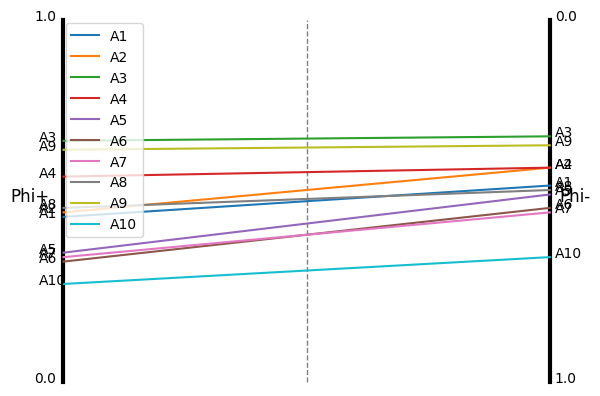

In [27]:
Fp, Fm = promethee(matrix, weights, types, promethee_I=True)
promethee_I_visualization(Fp, Fm)

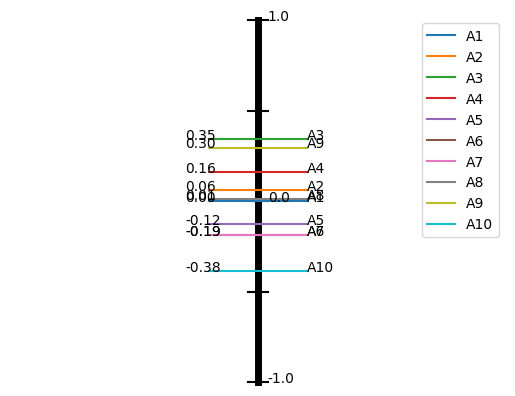

In [28]:
Fi = promethee(matrix, weights, types)
promethee_II_vizualization(Fi)

Here's also another way to show PROMETHEE's I partial ranking in nice-looking way:

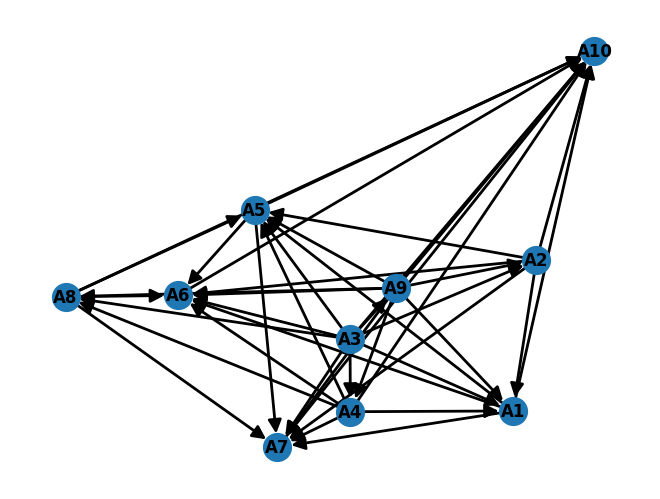

In [29]:
def check_pref(fp1, fm1, fp2, fm2):
    '''Returns:
    1 if preference
    0 if indifference
    -1 if incomparability
    '''
    if fp1 == fp2 and fm1 == fm2:
        return 0 # Indifference

    elif (fp1 > fp2 and fm1 < fm2)\
            or (fp1 == fp2 and fm1 < fm2)\
            or (fp1 > fp2 and fm1 == fm2):
        return 1
    else:
        return -1


def promethee_I_graph(Fp, Fm):
    G = nx.DiGraph()

    for i in range(len(Fp)):
        G.add_node(f'A{i+1}')

    for i in range(len(Fp)):
        for j in range(len(Fp)):
            if check_pref(Fp[i], Fm[i], Fp[j], Fm[j]) == 1:
                G.add_edge(f'A{i+1}', f'A{j+1}')

    nx.draw(G, with_labels=True, font_weight='bold',
            width=2, arrowsize=20, node_size=400)

promethee_I_graph(Fp, Fm)

### COPRAS method

**Important**: This methods requires at least one cost criterion in the decision problem.

In [30]:
copras = mcdm_methods.COPRAS()
pref = copras(matrix, weights, types)

In [31]:
print(tabulate([['Preference', *np.round(pref, 2)],
                ['Rank', *rrankdata(pref)]],
              headers=[''] + [f'A{i+1}' for i in range(10)]))

              A1    A2    A3    A4    A5    A6    A7    A8    A9    A10
----------  ----  ----  ----  ----  ----  ----  ----  ----  ----  -----
Preference     1  0.93  0.72  0.68  0.68  0.65  0.53  0.56  0.75   0.39
Rank           1  2     4     5     6     7     9     8     3     10


### SPOTIS method
This method is required some additional data: criteria bounds. Becaues it is not provided with definition of the problem, we could determine it based on decision matrix.

**Important**: min and max values should be different for each criterion. If you have criterion which has equal values for each attribute, you should consider removing this criterion, use another method or provide bounds which would be different.

In [32]:
bounds =  np.vstack((
    np.min(matrix, axis=0),
    np.max(matrix, axis=0)
)).T
print(bounds)

[[ 340.  3000. ]
 [  57.   150. ]
 [ 100.   180. ]
 [  10.   200. ]
 [  80.   610. ]
 [   4.    10. ]
 [  10.   120. ]
 [  10.5   99. ]
 [  12.9  120. ]]


And then it could be applied like other methods:

In [33]:
spotis = mcdm_methods.SPOTIS()
pref = spotis(matrix, weights, types, bounds=bounds)

In [34]:
print(tabulate([['Preference', *np.round(pref, 3)],
                ['Rank', *rankdata(pref)]],
              headers=[''] + [f'A{i+1}' for i in range(10)]))

               A1     A2     A3     A4     A5     A6     A7     A8     A9     A10
----------  -----  -----  -----  -----  -----  -----  -----  -----  -----  ------
Preference  0.446  0.452  0.414  0.428  0.579  0.596  0.589  0.549  0.365   0.802
Rank        4      5      2      3      7      9      8      6      1      10


### COMET method
To apply this method some additional information is also needed. We should provide characteristical values which would be used to create characteristical objects. Here we use three characteristical values, but it could be any number bigger then two.

**Important**: Characteristic values for each criterion should be sorted and does not contain repeated values.

In [35]:
cvalues =  np.vstack((
    np.min(matrix, axis=0),
    np.mean(matrix, axis=0),
    np.max(matrix, axis=0)
)).T
print(cvalues)

[[ 340.    909.3  3000.  ]
 [  57.    107.3   150.  ]
 [ 100.    144.    180.  ]
 [  10.     87.9   200.  ]
 [  80.    325.8   610.  ]
 [   4.      7.     10.  ]
 [  10.     54.    120.  ]
 [  10.5    37.57   99.  ]
 [  12.9    43.3   120.  ]]


Next thing which we need it's a `expert_function` or a `rate_function`, which would be used to compare characteristic objects (CO). There are two build-in options: `manual_expert` which is a expert function which allows to compare CO manually. The other one is a `topsis_rate_function` which allows to rate CO with TOPSIS in order to obtain SJ and P without building MEJ matrix.

In [36]:
comet = mcdm_methods.COMET(cvalues,
                           MethodExpert(mcdm_methods.TOPSIS(), weights, types))

In [37]:
pref = comet(matrix)

In order to use `rankdata` function with COMET results, it should be reversed by `reverse` argument.

In [38]:
print(tabulate([['Preference', *np.round(pref, 3)],
                ['Rank', *rrankdata(pref)]],
              headers=[''] + [f'A{i+1}' for i in range(10)]))

              A1     A2     A3     A4    A5     A6     A7     A8     A9     A10
----------  ----  -----  -----  -----  ----  -----  -----  -----  -----  ------
Preference  0.61  0.603  0.674  0.651  0.41  0.385  0.371  0.441  0.745   0.082
Rank        4     5      2      3      7     8      9      6      1      10


Here's another example with smaller number of characteristic values to show how `manual_expert` could be used. Consider that one criterion is a profit and other one is a cost.

In [39]:
cvalues = np.array([
    [1, 2],
    [3, 4],
], dtype='float')
criteria_names = ['Profit', 'Cost']

In [40]:
comet = mcdm_methods.COMET(cvalues,
                           expert_function=ManualExpert(criteria_names))

You need to evaluate 4 characteristic objects.
It will require 6 pairwise comparisons.

Characteristic Objects to be evaluated:
┌─────┬──────────┬────────┐
│     │  Profit  │  Cost  │
├─────┼──────────┼────────┤
│  A  │    1     │   3    │
├─────┼──────────┼────────┤
│  B  │    1     │   4    │
├─────┼──────────┼────────┤
│  C  │    2     │   3    │
├─────┼──────────┼────────┤
│  D  │    2     │   4    │
└─────┴──────────┴────────┘

=================================== 1 / 6 ======================================

Evaluate following characteristic objects:
┌─────┬──────────┬────────┐
│     │  Profit  │  Cost  │
├─────┼──────────┼────────┤
│  A  │    1     │   3    │
├─────┼──────────┼────────┤
│  B  │    1     │   4    │
└─────┴──────────┴────────┘

Input "A" if A is better.
Input "B" if B is better
Leave empty for the tie.
>>> A

=================================== 2 / 6 ======================================

Evaluate following characteristic objects:
┌─────┬──────────┬────────┐
│    

After building the model, we could visualize MEJ matrix with function like that:

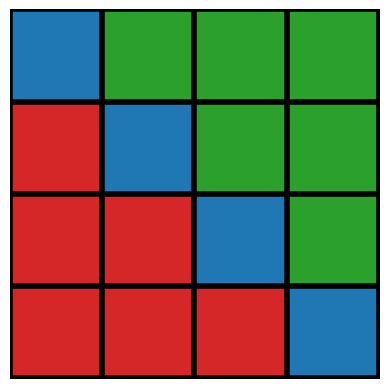

In [41]:
def draw_mej(mej, grid_width=2):
    ax = plt.gca()
    cmap = ListedColormap(['tab:red', 'tab:blue', 'tab:green'])
    im = ax.imshow(mej, cmap=cmap)
    
    for edge, spine in ax.spines.items():
        spine.set_visible(False)
        
    ax.set_xticks(np.arange(mej.shape[1]+1)-0.51, minor=True)
    ax.set_yticks(np.arange(mej.shape[0]+1)-0.51, minor=True)
    
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    ax.grid(which='minor', color='k', linestyle='-', linewidth=grid_width)
    ax.tick_params(which='minor')

draw_mej(comet.get_MEJ(), grid_width=4)

# Correlation coefficients
There are several correlation coefficients in our lib, but they generally work in the same way. This functions allows to compare rankings to determine how similar they are.

In [42]:
a = np.array([1, 2, 3, 4], dtype='float')
b = np.array([1, 2, 3, 4], dtype='float')

corr.weighted_spearman(a, b)

1.0

In [43]:
a = np.array([1, 2, 3, 4], dtype='float')
b = np.array([4, 3, 1, 2], dtype='float')

corr.weighted_spearman(a, b)

-0.8

In [44]:
a = np.array([1, 2, 3, 4], dtype='float')
b = np.array([1, 3, 4, 2], dtype='float')

corr.weighted_spearman(a, b)

0.52